## Development of access functions

To do
- Automate pull of data from OSM
- Get POIs (Schools?)
- Get OAs for area of study
- Get demographic data for area of study
- Routing (use old for now)
- Apply gravity model
- Visualisation of results

In [1]:
#Import packages
import OSM2AT
import osmnx as ox
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon, box
from geopandas import GeoDataFrame
import pickle
from sklearn.neighbors import NearestNeighbors
import networkx as nx
import pandas as pd
import heapq
import random

def get_key_with_lowest_value(my_dict):
    if not my_dict:
        return None
    
    return min(my_dict, key=lambda k: my_dict[k])

#From ChatGPT
def access_sp(G, origin, destination, access_cost, user_time):
    # Initialize distances with infinity for all nodes except the start node
    access_costs = {node: float('infinity') for node in G}
    access_time = {node: float('infinity') for node in G}
    access_costs[origin] = 0

    # Priority queue to keep track of the nodes to visit next
    priority_queue = [(0,0,origin)]

    while priority_queue:
        # Get the node with the smallest distance
        current_distance,current_time,current_node = heapq.heappop(priority_queue)

        # Check if the destination is reached
        if current_node == destination:
            break

        # Check if the current distance is already greater than the known distance
        if current_distance > access_costs[current_node]:
            continue

        # Explore neighbors and update distances
        for neighbor, weight in G[current_node].items():
            distance = current_distance + weight[0][access_cost]
            time_to_node = current_time + weight[0][user_time]
            # If a shorter path is found, update the distance
            if distance < access_costs[neighbor]:
                access_costs[neighbor] = distance
                access_time[neighbor] = time_to_node
                heapq.heappush(priority_queue, (distance, time_to_node, neighbor))

    return access_costs[destination], access_time[destination]

#From ChatGPT
def distance_decay(distance_array, exponent):
    """
    Calculate distance decay values for an array of distances using an exponent.

    Args:
    - distance_array (numpy array or list): Array of distances from a source.
    - exponent (float): Exponent value for the decay function.

    Returns:
    - decay_values (numpy array): Array of decay values corresponding to the distances.
    """
    decay_values = np.exp(-exponent * distance_array)  # Exponential decay formula
    return decay_values

c:\Users\cconlan\AppData\Local\anaconda3\envs\ate-bike\lib\site-packages\OSM2AT\get_at_networks.py:31: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(use_cache=True, log_console=True, useful_tags_way=utw)


In [2]:
# Paramters
exponent = 0.00115
output_area = 'Data/Examples/South London'
#Select area of study
#York - -1.135368,53.937294,-1.021900,53.985973
#South London - -0.097933,51.457054,-0.041285,51.486933
bounding_box = tuple([-0.097933,51.457054,-0.041285,51.486933])

## Select Area of Study

- Select bounding box for area of study
- Select expanded bounding box to bring through large network as POIs can be outside area of study
- Get cycle network frmo OSM2AT
- Output to file

### To Do 
- Fully parameterise expanded bounding box

In [3]:
#Get expanded bounding box
bbox_width = abs(bounding_box[0] - bounding_box[2])
print(bbox_width)
bbox_height = abs(bounding_box[1] - bounding_box[3])
print(bbox_height)
expanded_bbox = tuple([bounding_box[0] - bbox_width,bounding_box[1] - bbox_height,bounding_box[2] + bbox_width,bounding_box[3] + bbox_height])

#Cycle network
impute_method = 'mode-rule'
mlp_train_params = {
    'hidden_layer' : 100,
    'n_epochs' : 50,
    'batch_size' : 10
}
lts_method = 'ottawa'
self_learn_k = 5

G,edges = OSM2AT.get_cycle_network(expanded_bbox,impute_method,mlp_train_params,lts_method,self_learn_k)

# Output to file
edge_attributes_gdf = GeoDataFrame(edges[['osmid','geometry','LTS']], crs="EPSG:4326", geometry=edges['geometry'])
edge_attributes_gdf.to_file("{}/network_with_lts.json".format(output_area), driver="GeoJSON")

# Save graph object to file
pickle.dump(G, open('{}/G.pickle'.format(output_area), 'wb'))

0.056648000000000004
0.0298790000000011


c:\Users\cconlan\AppData\Local\anaconda3\envs\ate-bike\lib\site-packages\OSM2AT\get_at_networks.py:52: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  edge_attributes['cent_x'] = edge_attributes['geometry'].centroid.x
c:\Users\cconlan\AppData\Local\anaconda3\envs\ate-bike\lib\site-packages\OSM2AT\get_at_networks.py:53: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  edge_attributes['cent_y'] = edge_attributes['geometry'].centroid.y


Imputing Max Speed
Imputing data using method - Mode Rule
Data imputed
Imputing Number of Lanes
Imputing data using method - Mode Rule
Data imputed
Imputing Surface
Imputing data using method - mode rule
Data imputed
Calculating LTS using Ottawa Advocacy Group method


## Get POIs - Schools

- Select amenity type from OSM and pull through for expanded network
- Drop relations (why?)
- Get POI centroid (if not node) and assign to its nearest node in G
- Save to file

### T0 do

-Consider efficiency

In [4]:
tags = {"amenity": 'school'} # (dict) – Dict of tags used for finding objects in the selected area: pois.
mypois = ox.features.features_from_bbox(expanded_bbox[3], expanded_bbox[1], expanded_bbox[2], expanded_bbox[0], tags) # the table

# pick the fields of interest
mypois = mypois[["amenity", "name", "geometry"]]

destination_centroids = []
for i,r in mypois.iterrows():
    if i[0] != 'relation':
        if i[0] == 'node':
            destination_centroids.append([r['geometry'].x,r['geometry'].y])
        else:
            destination_centroids.append([r['geometry'].centroid.x,r['geometry'].centroid.y])

destination_nodes = ox.nearest_nodes(G,np.array(destination_centroids)[:,0],np.array(destination_centroids)[:,1])

# create a geodataframe in a specific CRS and save the result into a GeoJson file
poi_gdf = gpd.GeoDataFrame(mypois, crs="EPSG:4326")
poi_gdf.set_geometry('geometry', crs={'init': 'epsg:4326'})
poi_gdf.to_file('{}/POI_schools.geojson'.format(output_area), driver='GeoJSON')

c:\Users\cconlan\AppData\Local\anaconda3\envs\ate-bike\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


## Read in OAs and assign to area of study

- Check if OA intersects with bounding box

### To Do

- Consider efficiency

In [5]:
#Get OAs
oas = gpd.read_file('Data/OAs/OA_2021_EW_BGC.shp').to_crs(4326)
bbox = box(bounding_box[0], bounding_box[1], bounding_box[2], bounding_box[3])
gpd.GeoSeries([bbox]).to_file('{}/area_of_study.geojson'.format(output_area), driver='GeoJSON')

ids = []
origin_centroids = []
count = 0
count_found = 0
for i,r in oas.iterrows():
    count += 1
    if count % 100 == 0:
        print(count / len(oas))
    if r['geometry'].intersects(bbox):
        count_found += 1
        ids.append(r['OA21CD'])

        origin_centroids.append([r['geometry'].centroid.x,r['geometry'].centroid.y])

print('Number found : {}'.format(count_found))
origin_nodes = ox.nearest_nodes(G,np.array(origin_centroids)[:,0],np.array(origin_centroids)[:,1])
oas_in_study = oas[oas['OA21CD'].isin(ids)]
oas_in_study = oas_in_study.set_index('OA21CD')

0.0005294366793731469
0.0010588733587462938
0.0015883100381194409
0.0021177467174925877
0.0026471833968657347
0.0031766200762388818
0.0037060567556120288
0.004235493434985175
0.004764930114358323
0.0052943667937314694
0.005823803473104617
0.0063532401524777635
0.006882676831850911
0.0074121135112240576
0.007941550190597205
0.00847098686997035
0.009000423549343498
0.009529860228716646
0.010059296908089793
0.010588733587462939
0.011118170266836086
0.011647606946209234
0.01217704362558238
0.012706480304955527
0.013235916984328674
0.013765353663701822
0.014294790343074968
0.014824227022448115
0.015353663701821263
0.01588310038119441
0.016412537060567556
0.0169419737399407
0.01747141041931385
0.018000847098686996
0.018530283778060146
0.01905972045743329
0.019589157136806437
0.020118593816179586
0.020648030495552732
0.021177467174925878
0.021706903854299027
0.022236340533672173
0.02276577721304532
0.023295213892418468
0.023824650571791613
0.02435408725116476
0.02488352393053791
0.02541296060

c:\Users\cconlan\AppData\Local\anaconda3\envs\ate-bike\lib\site-packages\pandas\core\algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


## Compute access costs

- Each OA centroid an origin point
- Compute the k nearest POIs to each origin point
- Create an O*K matrix
- Get shortest path for each OK pair according to somre defined access cost

### Possible to do's
- Randomise j start points in an OA e.g., randomly select some nodes

In [6]:
#Get routes for different user types

#Get closest k schools
k = 20
nn_model = NearestNeighbors(n_neighbors=k)
nn_model.fit(destination_centroids)
access_cost = 'ac_beginner'
user_time = 'time_beginner'

distances, dest_inds = nn_model.kneighbors(origin_centroids)

#%%
access_matrix = np.zeros((len(origin_nodes),k))
time_matrix = np.zeros((len(origin_nodes),k))

o_ind = 0
origin_unreachable = []
dest_unreachable = []

for o in origin_nodes:
    print(o_ind / len(origin_nodes))
    d_ind_mx = 0
    for d_ind in dest_inds[o_ind]:
        d = destination_nodes[d_ind]
        try:
            cost,time = access_sp(G, o, d, access_cost, user_time)
            access_matrix[o_ind,d_ind_mx] = cost
            time_matrix[o_ind,d_ind_mx] = time
        except:
            origin_unreachable.append(o)
            dest_unreachable.append(d)
        d_ind_mx += 1
    o_ind += 1

0.0
0.0019569471624266144
0.003913894324853229
0.005870841487279843
0.007827788649706457
0.009784735812133072
0.011741682974559686
0.0136986301369863
0.015655577299412915
0.01761252446183953
0.019569471624266144
0.021526418786692758
0.023483365949119372
0.025440313111545987
0.0273972602739726
0.029354207436399216
0.03131115459882583
0.033268101761252444
0.03522504892367906
0.03718199608610567
0.03913894324853229
0.0410958904109589
0.043052837573385516
0.04500978473581213
0.046966731898238745
0.04892367906066536
0.050880626223091974
0.05283757338551859
0.0547945205479452
0.05675146771037182
0.05870841487279843
0.060665362035225046
0.06262230919765166
0.06457925636007827
0.06653620352250489
0.0684931506849315
0.07045009784735812
0.07240704500978473
0.07436399217221135
0.07632093933463796
0.07827788649706457
0.08023483365949119
0.0821917808219178
0.08414872798434442
0.08610567514677103
0.08806262230919765
0.09001956947162426
0.09197651663405088
0.09393346379647749
0.0958904109589041
0.097

## Implement gravity model

- Operate dist decay over matrix
- Output

### To do

- Calibrate model
- Measure of attrativeness

In [7]:
#Gravity Model
decay_array = distance_decay(access_matrix, exponent)
access_scores = decay_array.sum(axis = 1)
oas_in_study['gravity score'] = access_scores

#Cumulative Opportunities
time_to_access_poi = 600
oas_in_study['cumulative opportunities'] = (time_matrix <= 600).sum(axis = 1)

## Demographic Data

- Read in relevant demographic groups (likely determined by POI type)
- Get demographic distribution
- Compute priority index
- Output at OA level

#### Notes

- Demographic sourced from (https://www.nomisweb.co.uk/sources/census_2021)
- ChatGPT used to develop some data wrangling functions

In [8]:
# Functions

#From chatgpt
def normalize_column(column):
    min_val = column.min()
    max_val = column.max()
    normalized_column = (column - min_val) / (max_val - min_val)
    return normalized_column

#From chatgpt
def compute_quartile(value, column):
    q1 = column.quantile(0.25)
    q2 = column.quantile(0.50)
    q3 = column.quantile(0.75)
    
    if value < q1:
        return 1
    elif value < q2:
        return 2
    elif value < q3:
        return 3
    else:
        return 4

def compute_quartile_reverse(value, column):
    q1 = column.quantile(0.25)
    q2 = column.quantile(0.50)
    q3 = column.quantile(0.75)
    
    if value < q1:
        return 4
    elif value < q2:
        return 3
    elif value < q3:
        return 2
    else:
        return 1

In [9]:
#People of School Age

# Get demographic data
age = pd.read_csv('Data/Demographic/age_bands_percent_oa.csv')
age = age.set_index('2021 output area')
oas_in_study['School Age Percent'] = age[['Aged 5 to 9 years','Aged 10 to 14 years', 'Aged 15 to 19 years']].sum(axis = 1)

# Apply the function to create a new column with quartile information
oas_in_study['Gravity Quartile'] = oas_in_study['gravity score'].apply(compute_quartile_reverse, column=oas_in_study['gravity score'])
oas_in_study['Opportunities Quartile'] = oas_in_study['cumulative opportunities'].apply(compute_quartile_reverse, column=oas_in_study['cumulative opportunities'])
oas_in_study['School Age Quartile'] = oas_in_study['School Age Percent'].apply(compute_quartile, column=oas_in_study['School Age Percent'])

# Classification of gravity score
oas_in_study['School Age Gravity Class'] = oas_in_study['Gravity Quartile'] * oas_in_study['School Age Quartile']
# Normalise
oas_in_study['School Age Gravity Class Normalised'] = normalize_column(oas_in_study['School Age Gravity Class'])

#Classification of cumulative opportunities
oas_in_study['School Age Opportunities Class'] = oas_in_study['Opportunities Quartile'] * oas_in_study['School Age Quartile']
# Normalise
oas_in_study['School Age Opportunities Class Normalised'] = normalize_column(oas_in_study['School Age Opportunities Class'])

In [10]:
#People with Access to Car

# Get demographic data
car = pd.read_csv('Data/Demographic/car_van_oa.csv')
car = car.set_index('2021 output area')

oas_in_study['No Car Percent'] = car['% no car']

# Apply the function to create a new column with quartile information
oas_in_study['Gravity Quartile'] = oas_in_study['gravity score'].apply(compute_quartile_reverse, column=oas_in_study['gravity score'])
oas_in_study['Opportunities Quartile'] = oas_in_study['cumulative opportunities'].apply(compute_quartile_reverse, column=oas_in_study['cumulative opportunities'])
oas_in_study['No Car Quartile'] = oas_in_study['No Car Percent'].apply(compute_quartile, column=oas_in_study['No Car Percent'])

# Classification of access need indicator
oas_in_study['No Car Gravity Class'] = oas_in_study['Gravity Quartile'] * oas_in_study['No Car Quartile']
# Normalise
oas_in_study['No Car Gravity Class Normalised'] = normalize_column(oas_in_study['No Car Gravity Class'])

#Classification of cumulative opportunities
oas_in_study['School Age Opportunities Class'] = oas_in_study['Opportunities Quartile'] * oas_in_study['No Car Quartile']
# Normalise
oas_in_study['School Age Opportunities Class Normalised'] = normalize_column(oas_in_study['School Age Opportunities Class'])

In [11]:
# Deprivation Indicator

# Get demographic data
deprived = pd.read_csv('Data/Demographic/deprivation_oa.csv')
deprived = deprived.set_index('2021 output area')

oas_in_study['Deprived Percent'] = deprived['% Deprived in one dimension']

# Apply the function to create a new column with quartile information
oas_in_study['Gravity Quartile'] = oas_in_study['gravity score'].apply(compute_quartile_reverse, column=oas_in_study['gravity score'])
oas_in_study['Opportunities Quartile'] = oas_in_study['cumulative opportunities'].apply(compute_quartile_reverse, column=oas_in_study['cumulative opportunities'])
oas_in_study['Deprived Quartile'] = oas_in_study['Deprived Percent'].apply(compute_quartile, column=oas_in_study['Deprived Percent'])

# Classification of access need indicator
oas_in_study['Deprived Gravity Class'] = oas_in_study['Gravity Quartile'] * oas_in_study['Deprived Quartile']
# Normalise
oas_in_study['Deprived Gravity Class Normalised'] = normalize_column(oas_in_study['Deprived Gravity Class'])

#Classification of cumulative opportunities
oas_in_study['School Age Opportunities Class'] = oas_in_study['Opportunities Quartile'] * oas_in_study['Deprived Quartile']
# Normalise
oas_in_study['School Age Opportunities Class Normalised'] = normalize_column(oas_in_study['School Age Opportunities Class'])

In [12]:
oas_in_study.to_file('{}/oa_level_analysis.geojson'.format(output_area), driver='GeoJSON')

In [13]:
#For 10 random OAs get isochone

# #max_travel_time = 900 (use time_to_access_poi)
for rand in range(10):
    try:
        limit_reached = False

        visited_nodes = []
        sp_to_nodes = {}
        sp_to_nodes_queue = {}

        start_node = random.choice(origin_nodes)
        sp_to_nodes[start_node] = 0
        sp_to_nodes_queue[start_node] = 0

        while not limit_reached:
            current_node = get_key_with_lowest_value(sp_to_nodes_queue)
            #Remove from queue
            del sp_to_nodes_queue[current_node]
            
            #Add to visited
            visited_nodes.append(current_node)
            
            #Distance to currently visited node
            dist_current_node = sp_to_nodes[current_node]
            
            if dist_current_node > time_to_access_poi:        
                limit_reached = True
            
            for n, weight in G[current_node].items():
                if n not in visited_nodes:
                    dist_to_neighbour = dist_current_node + weight[0][user_time]
                    if n not in list(sp_to_nodes.keys()):
                        sp_to_nodes[n] = dist_to_neighbour
                        sp_to_nodes_queue[n] = dist_to_neighbour
                    elif dist_to_neighbour < sp_to_nodes[n]:
                        sp_to_nodes[n] = dist_to_neighbour
                        sp_to_nodes_queue[n] = dist_to_neighbour

        # Intersect visisted nodes with edge attributes
        nodes_visited = ox.graph_to_gdfs(G, nodes=True)[0].loc[visited_nodes]
        nodes_visited['access cost'] = pd.Series(sp_to_nodes)

        #Output isochrone
        edge_attributes_gdf = GeoDataFrame(nodes_visited, crs="EPSG:4326", geometry=nodes_visited['geometry'])
        edge_attributes_gdf.to_file('{}/isocrone_{}.geojson'.format(output_area,rand), driver="GeoJSON")
    except:
        continue

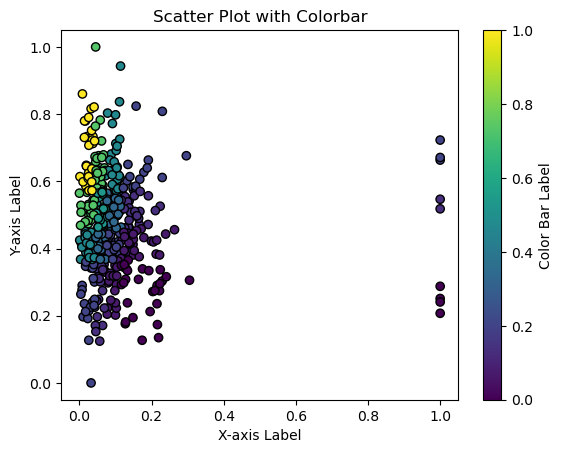

In [16]:
from matplotlib import pyplot as plt

plt.scatter(oas_in_study['Access Score Norm'].values, oas_in_study['Deprived Pcnt Norm'].values, c=oas_in_study['Deprived Access Class Normalised'].values, cmap='viridis', marker='o', edgecolors='black')

# Add a colorbar
cbar = plt.colorbar()
cbar.set_label('Color Bar Label')

# Set labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Scatter Plot with Colorbar')

# Show the plot
plt.show()

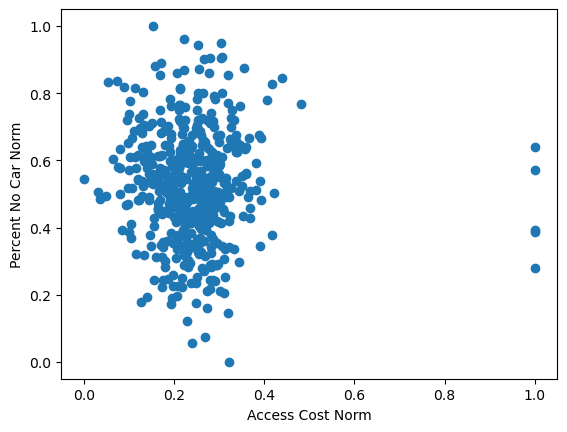

In [170]:
plt.scatter(oas_in_study['Access Score Norm'].values,oas_in_study['Deprived Pcnt Norm'].values)
plt.xlabel('Access Cost Norm')
plt.ylabel('Percent No Car Norm')
plt.show()

### Get POIs - Public Transit Stops

In [14]:
tags = {"railway": 'station'} # (dict) – Dict of tags used for finding objects in the selected area: pois.
mypois = ox.features.features_from_bbox(expanded_bbox[3], expanded_bbox[1], expanded_bbox[2], expanded_bbox[0], tags) # the table

# pick the fields of interest
mypois = mypois[["geometry"]]

destination_centroids = []
for i,r in mypois.iterrows():
    if i[0] != 'relation':
        if i[0] == 'node':
            destination_centroids.append([r['geometry'].x,r['geometry'].y])
        else:
            destination_centroids.append([r['geometry'].centroid.x,r['geometry'].centroid.y])

destination_nodes = ox.nearest_nodes(G,np.array(destination_centroids)[:,0],np.array(destination_centroids)[:,1])

# create a geodataframe in a specific CRS and save the result into a GeoJson file
poi_gdf = gpd.GeoDataFrame(mypois, crs="EPSG:4326")
poi_gdf.set_geometry('geometry', crs={'init': 'epsg:4326'})
poi_gdf.to_file('{}/POI_stations.geojson'.format(output_area), driver='GeoJSON')

c:\Users\cconlan\AppData\Local\anaconda3\envs\ate-bike\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
c:\Users\cconlan\AppData\Local\anaconda3\envs\ate-bike\lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
c:\Users\cconlan\AppData\Local\anaconda3\envs\ate-bike\lib\site-packages\pandas\core\algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.

In [15]:
#Get routes for different user types

access_cost = 'ac_beginner'
user_time = 'time_beginner'

#Get closest k schools
k = 20
inp_k = min([len(destination_nodes),k])

if len(destination_nodes) > inp_k:
    nn_model = NearestNeighbors(n_neighbors=inp_k)
    nn_model.fit(destination_centroids)
    distances, dest_inds = nn_model.kneighbors(origin_centroids)
    
    #%%
    access_matrix = np.zeros((len(origin_nodes),inp_k))
    time_matrix = np.zeros((len(origin_nodes),inp_k))

    o_ind = 0
    origin_unreachable = []
    dest_unreachable = []

    for o in origin_nodes:
        print(o_ind / len(origin_nodes))
        d_ind_mx = 0
        for d_ind in dest_inds[o_ind]:
            d = destination_nodes[d_ind]
            try:
                cost,time = access_sp(G, o, d, access_cost, user_time)
                access_matrix[o_ind,d_ind_mx] = cost
                time_matrix[o_ind,d_ind_mx] = time
            except:
                origin_unreachable.append(o)
                dest_unreachable.append(d)
            d_ind_mx += 1
        o_ind += 1
else:
    #%%
    access_matrix = np.zeros((len(origin_nodes),inp_k))
    time_matrix = np.zeros((len(origin_nodes),inp_k))

    o_ind = 0
    origin_unreachable = []
    dest_unreachable = []

    for o in origin_nodes:
        print(o_ind / len(origin_nodes))
        d_ind_mx = 0
        for d in destination_nodes:
            try:
                cost,time = access_sp(G, o, d, access_cost, user_time)
                access_matrix[o_ind,d_ind_mx] = cost
                time_matrix[o_ind,d_ind_mx] = time
            except:
                origin_unreachable.append(o)
                dest_unreachable.append(d)
            d_ind_mx += 1
        o_ind += 1

0.0
0.0019569471624266144
0.003913894324853229
0.005870841487279843
0.007827788649706457
0.009784735812133072
0.011741682974559686
0.0136986301369863
0.015655577299412915
0.01761252446183953
0.019569471624266144
0.021526418786692758
0.023483365949119372
0.025440313111545987
0.0273972602739726
0.029354207436399216
0.03131115459882583
0.033268101761252444
0.03522504892367906
0.03718199608610567
0.03913894324853229
0.0410958904109589
0.043052837573385516
0.04500978473581213
0.046966731898238745
0.04892367906066536
0.050880626223091974
0.05283757338551859
0.0547945205479452
0.05675146771037182
0.05870841487279843
0.060665362035225046
0.06262230919765166
0.06457925636007827
0.06653620352250489
0.0684931506849315
0.07045009784735812
0.07240704500978473
0.07436399217221135
0.07632093933463796
0.07827788649706457
0.08023483365949119
0.0821917808219178
0.08414872798434442
0.08610567514677103
0.08806262230919765
0.09001956947162426
0.09197651663405088
0.09393346379647749
0.0958904109589041
0.097

In [16]:
#Gravity Model
decay_array = distance_decay(access_matrix, exponent)
access_scores = decay_array.sum(axis = 1)
oas_in_study['gravity score trains'] = access_scores

#Cumulative Opportunities
time_to_access_poi = 600
oas_in_study['cumulative opportunities trains'] = (time_matrix <= 600).sum(axis = 1)

In [17]:
#People with Access to Car

# Get demographic data
car = pd.read_csv('Data/Demographic/car_van_oa.csv')
car = car.set_index('2021 output area')

oas_in_study['No Car Percent'] = car['% no car']

# Apply the function to create a new column with quartile information
oas_in_study['Gravity Quartile Train'] = oas_in_study['gravity score trains'].apply(compute_quartile_reverse, column=oas_in_study['gravity score trains'])
oas_in_study['Opportunities Quartile Train'] = oas_in_study['cumulative opportunities trains'].apply(compute_quartile_reverse, column=oas_in_study['cumulative opportunities trains'])
oas_in_study['No Car Quartile'] = oas_in_study['No Car Percent'].apply(compute_quartile, column=oas_in_study['No Car Percent'])

# Classification of access need indicator
oas_in_study['No Car Gravity Class Train'] = oas_in_study['Gravity Quartile Train'] * oas_in_study['No Car Quartile']
# Normalise
oas_in_study['No Car Gravity Class Normalised Train'] = normalize_column(oas_in_study['No Car Gravity Class Train'])

#Classification of cumulative opportunities
oas_in_study['School Age Opportunities Class Train'] = oas_in_study['Opportunities Quartile Train'] * oas_in_study['No Car Quartile']
# Normalise
oas_in_study['School Age Opportunities Class Normalised Train'] = normalize_column(oas_in_study['School Age Opportunities Class Train'])

In [18]:
oas_in_study.to_file('{}/oa_level_analysis_trains.geojson'.format(output_area), driver='GeoJSON')

In [19]:
oas_in_study.columns

Index(['GlobalID', 'geometry', 'gravity score', 'cumulative opportunities',
       'School Age Percent', 'Gravity Quartile', 'Opportunities Quartile',
       'School Age Quartile', 'School Age Gravity Class',
       'School Age Gravity Class Normalised', 'School Age Opportunities Class',
       'School Age Opportunities Class Normalised', 'No Car Percent',
       'No Car Quartile', 'No Car Gravity Class',
       'No Car Gravity Class Normalised', 'Deprived Percent',
       'Deprived Quartile', 'Deprived Gravity Class',
       'Deprived Gravity Class Normalised', 'gravity score trains',
       'cumulative opportunities trains', 'Gravity Quartile Train',
       'Opportunities Quartile Train', 'No Car Gravity Class Train',
       'No Car Gravity Class Normalised Train',
       'School Age Opportunities Class Train',
       'School Age Opportunities Class Normalised Train'],
      dtype='object')

In [26]:
edges[['maxspeed','highway','lanes','cycleway']]

maxspeed       highway  lanes
u           v           key                               
102010      1620855434  0          20   residential    2.0
104318      7946372941  0          20       primary    2.0
            3817308660  0          20       primary    2.0
            4076126448  0          20  unclassified    2.0
104319      9781311298  0          20       primary    2.0
...                               ...           ...    ...
11377592656 11377592657 0          20      cycleway    2.0
11377592657 5337281233  0          20      cycleway    2.0
11377592658 5374121239  0          20       primary    2.0
            11377592655 0          20      cycleway    2.0
11378342217 7400989191  0          20  unclassified    2.0

[260425 rows x 3 columns]

In [27]:
edges['cycleway'].value_counts()

no                2039
crossing          1784
sidewalk          1529
opposite          1439
share_busway       782
lane               740
separate           357
shared             294
track               44
traffic_island      42
segregated          38
link                30
advisory            22
both                14
none                 8
right                6
cycleway             4
asphalt              2
Name: cycleway, dtype: int64